Revised version of amazon.ipynb

In [ ]:
import sys
import os
from typing import Literal

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import keras
from keras import layers
from keras import ops
from keras.callbacks import EarlyStopping

# Import utils from subfolder of project, works for immediate subfolders of PROJECT_ROOT
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) # adjust relative import as necessary
SELECTED_CATEGORY = 'Video_Games'
sys.path.append(PROJECT_ROOT)
from utils.data_processing import get_filtered_review_data, get_metadata, compute_user_bias

Data preprocessing is mostly outsourced to utils/data_processing.py

However, we need to get the combined number of products and compute user bias

In [ ]:
# Fetch interaction data
X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(SELECTED_CATEGORY, 10, include_columns=['user_id', 'product_id'])

metadata = get_metadata(SELECTED_CATEGORY)
product_ids = metadata['parent_asin']

# Total users and products needed for constructing a matrix that represents the entire interaction space
num_users = len(pd.concat([X_train['user_id'], X_val['user_id'], X_test['user_id']]).unique())
num_products = len(pd.concat([X_train['product_id'], X_val['product_id'], X_test['product_id']]).unique())

# Adjusting for user bias, will be re-added in final evaluation
y_norm, user_bias = compute_user_bias([X_train, X_val], [y_train, y_val])
y_train_norm, y_val_norm = y_norm
y_train_norm

X_train, X_val, X_test = X_train.values, X_val.values, X_test.values

In [ ]:
# Original recommender network
# Using matrix factorization to find embeddings

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    min_delta=0.001,
    mode='min',
    restore_best_weights=True
)

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_products, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.product_embedding = layers.Embedding(
            num_products,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.product_bias = layers.Embedding(num_products, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        product_vector = self.product_embedding(inputs[:, 1])
        product_bias = self.product_bias(inputs[:, 1])

        dot_user_product = ops.tensordot(user_vector, product_vector, 2)
        a = dot_user_product + user_bias + product_bias
        return ops.nn.sigmoid(a)

In [ ]:
def new_model(embedding_size: int = 1, user_bias_norm: bool = False) -> keras.Model:
    model = RecommenderNet(num_users, num_products, embedding_size)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
    )

    if user_bias_norm:
        history = model.fit(
            x=X_train,
            y=y_train_norm,
            batch_size=64,
            epochs=100,
            verbose=1,
            validation_data=(X_val, y_val_norm),
            callbacks=[early_stopping]
        )

    else:
        history = model.fit(
            x=X_train,
            y=y_train,
            batch_size=64,
            epochs=100,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping]
        )

    return model, history

def plot_history(history):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Evaluation

In [34]:
from sklearn.metrics import mean_squared_error

class identity_model():
    """
    Rates every user-product pair equally
    Adding user bias can improve score significantly as a regression benchmark
    """
    def __init__(self):
        pass

    def predict(self, X):
        return np.zeros(X.shape[0])
base = identity_model()

def test_regression(model, X: np.ndarray, y: np.ndarray, add_user_bias: bool = False):
    y_pred = model.predict(X).flatten()

    # re-incorporate user_bias if it was normalized away
    if add_user_bias:
        y_pred += user_bias[X[:,0]]

    return mean_squared_error(y, y_pred)

print(f'Identity Model: {test_regression(base, X_test, y_test, add_user_bias=True)}')


Identity Model: 0.07077902638563877


In [ ]:
test = np.hstack((X_test, np.array(y_test).reshape(-1,1)))
test_pos = test[test[:,2] > 0.5]

X_test_pos = test_pos[:,:2]
y_test_pos = test_pos[:, 2]
test_ranking(model, X_test_pos, y_test_pos)

In [ ]:
def test_ranking(model, X, y, batch_size=1000):
    """
    Evaluate recommendation model by calculating mean percentile rankings.
    Lower values indicate better performance.

    Parameters:
        model: TensorFlow model with predict method
        X: Array of (user_id, product_id) pairs
        y: Target values
        batch_size: Batch size for model predictions

    Returns:
        float: Mean percentile rank (0=perfect, 1=worst)
    """
    import numpy as np
    from tqdm import tqdm
    from collections import defaultdict

    products = np.arange(num_products)

    # Group by user to minimize predictions
    user_products = defaultdict(list)
    for i, (user_id, product_id) in enumerate(X):
        user_products[user_id].append((i, product_id))

    placements = np.zeros(len(X))

    # Process users in batches
    users = list(user_products.keys())
    for i in tqdm(range(0, len(users), batch_size)):
        batch_users = users[i:i+batch_size]

        for user_id in batch_users:
            # Get all target products for this user
            user_targets = user_products[user_id]

            # Create input for all products for this user
            user_all_products = np.column_stack([
                np.full(len(products), user_id),
                products
            ])

            # Get all ratings for this user
            all_ratings = model.predict(user_all_products, verbose=0).flatten()

            # Sort ratings in descending order
            sorted_indices = np.argsort(-all_ratings)

            # Calculate percentile rank for each target
            for idx, product_id in user_targets:
                product_pos = np.where(products == product_id)[0][0]
                rating = all_ratings[product_pos]

                # Find position (how many items have higher ratings)
                rank = np.sum(all_ratings > rating)
                percentile = rank / len(products)

                placements[idx] = percentile

    return np.mean(placements)

Loading preprocessed data from data/Video_Games_min5_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min6_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min7_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min8_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min9_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min10_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min11_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min12_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min13_testfrac0.20_cols['user_id', 'product_id'].pkl
Loading preprocessed data from data/Video_Games_min14_testfrac0.20_cols['user_id', 'product_id']

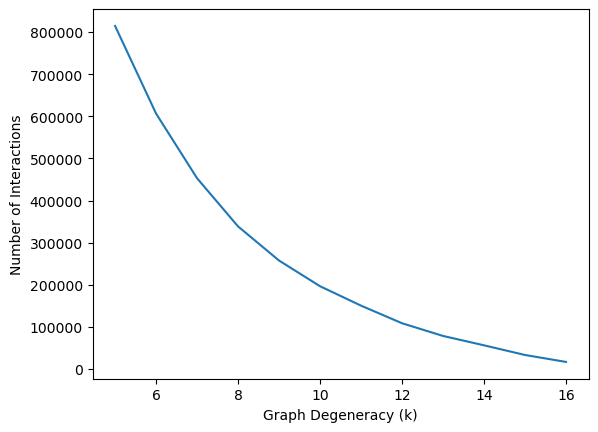

In [37]:
# Plot number of interactions per threshold
interactions = []
k_vals = range(5,17)
for k in k_vals:
    X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(SELECTED_CATEGORY, k, include_columns=['user_id', 'product_id'])
    total_labels = len(y_train) + len(y_val) + len(y_test)
    interactions.append(total_labels)

plt.plot(k_vals, interactions)
plt.xlabel('Graph Degeneracy (k)')
plt.ylabel('Number of Interactions')
plt.show()

Loading preprocessed data from data/Video_Games_min10_testfrac0.20_cols['user_id', 'product_id'].pkl


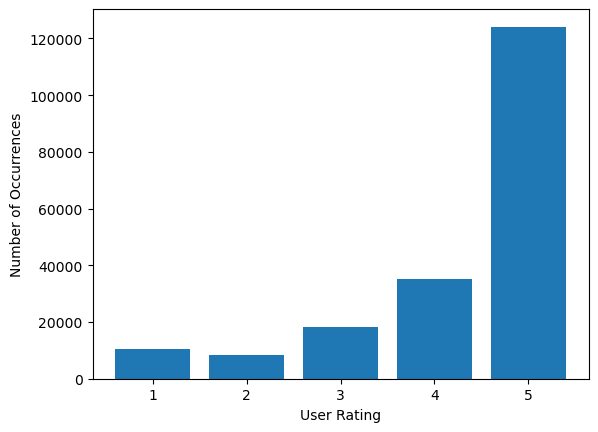

In [36]:
# Rating distribution for optimal k value
optimal_k = 10

X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(SELECTED_CATEGORY, optimal_k, include_columns=['user_id', 'product_id'])
labels = np.concatenate((y_train, y_val, y_test)) * 4 + 1

plt.hist(labels, bins=np.arange(0.5, 5.5+1, 1), rwidth=0.8, align='mid')
plt.xticks([1, 2, 3, 4, 5])  
plt.xlabel('User Rating')  
plt.ylabel('Number of Occurrences')  
plt.show()

In [ ]:
# Tune regression settings to best degeneracy level
models = []
embedding_size = 2
k_vals = range(5,17)
for k in tqdm(k_vals):
    X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(SELECTED_CATEGORY, k, include_columns=['user_id', 'product_id'])
    
    # Preprocessing step
    num_users = len(pd.concat([X_train['user_id'], X_val['user_id'], X_test['user_id']]).unique())
    num_products = len(pd.concat([X_train['product_id'], X_val['product_id'], X_test['product_id']]).unique())
    y_norm, user_bias = compute_user_bias([X_train, X_val], [y_train, y_val])
    # y_train_norm, y_val_norm = y_norm
    X_train, X_val, X_test = X_train.values, X_val.values, X_test.values

    model = RecommenderNet(num_users, num_products, embedding_size)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=64,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    models.append((model, history))

Loading preprocessed data from data/Video_Games_min16_testfrac0.20_cols['user_id', 'product_id'].pkl
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
Loading preprocessed data from data/Video_Games_min16_testfrac0.20_cols['user_id', 'product_id'].pkl
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
Loading preprocessed data from data/Video_Games_min16_testfrac0.20_cols['user_id', 'product_id'].pkl
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
Loading preprocessed data from data/Video_Games_min16_testfrac0.20_cols['user_id', 'product_id'].pkl
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
Loading preprocessed data from data/Video_Games_min16_testfrac0.20_cols['user_id', 'product_id'].pkl
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Loading preprocessed data from data/Video_Games_min16_testfrac0.20_cols['user_id', 'product_id'].pkl
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Loading preprocessed data from data/Video_Games_min16_testfrac0.20_cols['user_id', 'product_id'].pkl
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Loading pr

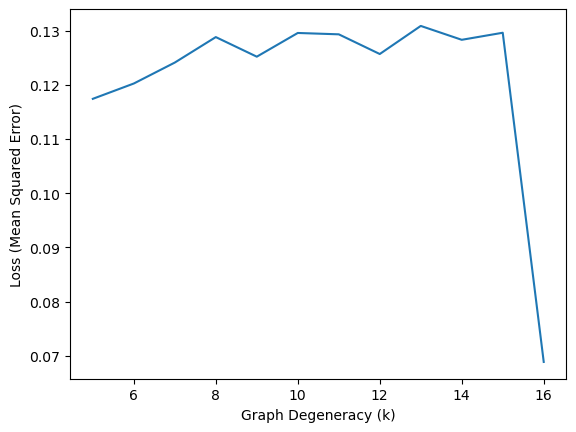

In [39]:
# Plot accuracy of model based on graph degeneracy

regression_accuracy = []
for i in range(len(k_vals)):
    X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(SELECTED_CATEGORY, k, include_columns=['user_id', 'product_id'])
    
    # Preprocessing step
    num_users = len(pd.concat([X_train['user_id'], X_val['user_id'], X_test['user_id']]).unique())
    num_products = len(pd.concat([X_train['product_id'], X_val['product_id'], X_test['product_id']]).unique())
    y_norm, user_bias = compute_user_bias([X_train, X_val], [y_train, y_val])
    # y_train_norm, y_val_norm = y_norm
    X_train, X_val, X_test = X_train.values, X_val.values, X_test.values

    model = models[i][0]
    regression_accuracy.append(test_regression(model, X_val, y_val))

plt.plot(k_vals, regression_accuracy)
plt.xlabel('Graph Degeneracy (k)')
plt.ylabel('Loss (Mean Squared Error)')
plt.show()

various_k_models = models

In [40]:
# Tuning model dimensions for k=5

dimensions = [1,2,3,4,5]
k = 5
tuning_models_5 = []

X_train, y_train, X_val, y_val, X_test, y_test = get_filtered_review_data(SELECTED_CATEGORY, k, include_columns=['user_id', 'product_id'])
    
# Preprocessing step
num_users = len(pd.concat([X_train['user_id'], X_val['user_id'], X_test['user_id']]).unique())
num_products = len(pd.concat([X_train['product_id'], X_val['product_id'], X_test['product_id']]).unique())
y_norm, user_bias = compute_user_bias([X_train, X_val], [y_train, y_val])
# y_train_norm, y_val_norm = y_norm
X_train, X_val, X_test = X_train.values, X_val.values, X_test.values

for dim in tqdm(dimensions):
    model = RecommenderNet(num_users, num_products, dim)
    model.compile(
        loss=keras.losses.BinaryCrossentropy(),
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=64,
        epochs=100,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    tuning_models_5.append((model, history))

Loading preprocessed data from data/Video_Games_min5_testfrac0.20_cols['user_id', 'product_id'].pkl


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6161 - val_loss: 0.4805
Epoch 2/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.4418 - val_loss: 0.4650
Epoch 3/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.4209 - val_loss: 0.4536
Epoch 4/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.4069 - val_loss: 0.4452
Epoch 5/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3960 - val_loss: 0.4392
Epoch 6/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3884 - val_loss: 0.4346
Epoch 7/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.3808 - val_loss: 0.4309
Epoch 8/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3754 - val_loss: 0.4279
Epoch 9/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3702 - val_loss: 0.4257
Epoch 10/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3681 - val_loss: 0.4241
Epoch 11/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.3639 - val_loss: 0.4231
Epoch 12

 20%|██        | 1/5 [05:20<21:21, 320.29s/it]

Epoch 1/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.6268 - val_loss: 0.4833
Epoch 2/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 0.4450 - val_loss: 0.4691
Epoch 3/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.4234 - val_loss: 0.4559
Epoch 4/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.4085 - val_loss: 0.4476
Epoch 5/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.3978 - val_loss: 0.4407
Epoch 6/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.3899 - val_loss: 0.4355
Epoch 7/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.3830 - val_loss: 0.4316
Epoch 8/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.3768 - val_loss: 0.4286
Epoch 9/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.3721 - val_loss: 0.4262
Epoch 10/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 0.3679 - val_loss: 0.4244
Epoch 11/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 0.3642 - val_loss: 0.4233
Epoch 12

 40%|████      | 2/5 [14:35<22:55, 458.58s/it]

Epoch 1/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 46s 4ms/step - loss: 0.5999 - val_loss: 0.4795
Epoch 2/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.4409 - val_loss: 0.4671
Epoch 3/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.4216 - val_loss: 0.4564
Epoch 4/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.4083 - val_loss: 0.4476
Epoch 5/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.3977 - val_loss: 0.4419
Epoch 6/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.3899 - val_loss: 0.4370
Epoch 7/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.3826 - val_loss: 0.4334
Epoch 8/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.3776 - val_loss: 0.4302
Epoch 9/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.3729 - val_loss: 0.4277
Epoch 10/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - loss: 0.3684 - val_loss: 0.4258
Epoch 11/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.3639 - val_loss: 0.4244
Epoch 12

 60%|██████    | 3/5 [24:26<17:17, 518.79s/it]

Epoch 1/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.6018 - val_loss: 0.4806
Epoch 2/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.4414 - val_loss: 0.4685
Epoch 3/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.4210 - val_loss: 0.4586
Epoch 4/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.4086 - val_loss: 0.4499
Epoch 5/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.3985 - val_loss: 0.4424
Epoch 6/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.3906 - val_loss: 0.4378
Epoch 7/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.3835 - val_loss: 0.4341
Epoch 8/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.3774 - val_loss: 0.4308
Epoch 9/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.3732 - val_loss: 0.4283
Epoch 10/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.3694 - val_loss: 0.4265
Epoch 11/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.3656 - val_loss: 0.4252
Epoch 12

 80%|████████  | 4/5 [33:01<08:37, 517.60s/it]

Epoch 1/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - loss: 0.6014 - val_loss: 0.4828
Epoch 2/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.4424 - val_loss: 0.4716
Epoch 3/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.4234 - val_loss: 0.4607
Epoch 4/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.4100 - val_loss: 0.4517
Epoch 5/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.3989 - val_loss: 0.4446
Epoch 6/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.3919 - val_loss: 0.4392
Epoch 7/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.3840 - val_loss: 0.4352
Epoch 8/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.3778 - val_loss: 0.4316
Epoch 9/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 0.3732 - val_loss: 0.4291
Epoch 10/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.3696 - val_loss: 0.4269
Epoch 11/100
9767/9767 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 0.3666 - val_loss: 0.4253
Epoch 12

100%|██████████| 5/5 [42:06<00:00, 505.24s/it]


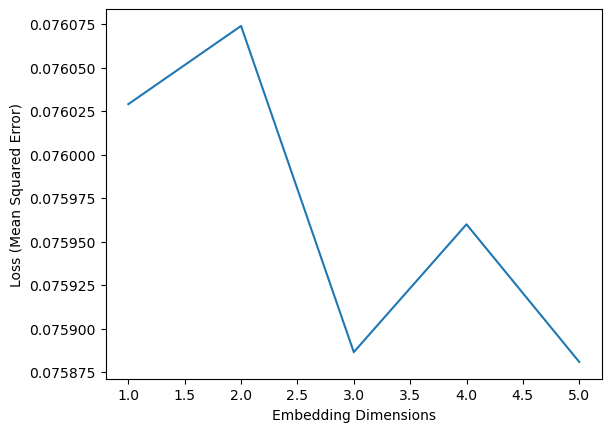

In [ ]:
regression_accuracy = []
for model, history in tuning_models_5:
    regression_accuracy.append(test_regression(model, X_val, y_val))

plt.plot(range(1,6), regression_accuracy)
plt.xlabel('Embedding Dimensions')
plt.ylabel('Loss (Mean Squared Error)')
plt.show()